In [18]:
import sys
sys.path.append("../../../")
from vision.occupancy_grid_cuda import CudaFrame
from model.physical_parameters import PhysicalParameters
from model.waypoint import Waypoint
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

def convert(path: str) -> list[Waypoint]:
    waypoints = []
    for line in path.strip().split('\n'):
        # Removing parentheses and splitting by comma
        x, y, h = map(int, line.strip('()').split(','))
        waypoints.append(Waypoint(x, y, h))
    return waypoints

def plot_vect(x, y, angle, length = 5) -> None:
    #angle = math.radians(angle)
    a = angle - math.pi/2
    end_x = x + length * np.cos(a)
    end_y = y + length * np.sin(a)
    plt.quiver(x, y, end_x - x, end_y - y, angles='xy', scale_units='xy', scale=1, color='r', label=f'Heading: {math.degrees(angle)}°')
    

def get_minmax(points: list[Waypoint]) -> tuple[int, int]:
    max_x = 0
    max_z = 0
    min_x = 256
    min_z = 256
    for p in points:
        max_x = max(max_x, p.x)
        max_z = max(max_z, p.z)
        min_x = min(min_x, p.x)
        min_z = min(min_z, p.z)        
    return max_x, max_z, min_x, min_z

def plot_points(points: list[Waypoint], show_heading_to: int = -1, show_heading_to_non_fesibles: list[bool] = None) -> Waypoint:
    
    max_x, max_z, min_x, min_z = get_minmax(points)
    
    x_coords = [p.x for p in points]
    y_coords = [p.z for p in points]
    
    # Create a scatter plot
    
    plt.xlim(min_x-10, max_x + 10)  # Set x-axis limits
    plt.ylim(min_z-10, max_z + 10)  # Set y-axis limits
    #plt.figure(figsize=(100, 60)) 
    plt.scatter(x_coords, y_coords, color='blue', label='Points')
    
    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.title('Planned path')
    
    
    plt.legend()

    if show_heading_to >= 0:
        x_h = points[show_heading_to].x
        y_h = points[show_heading_to].z
        h = points[show_heading_to].heading
        plt.scatter(x_h, y_h, color='red', label='Heading')
        plot_vect(x_h, y_h, h, 10)
        print(points[show_heading_to])
    else:
        if show_heading_to_non_fesibles is None:
            for p in points:
                x_h = p.x
                y_h = p.z
                h = p.heading
                #plt.scatter(x_h, y_h, color='red', label='Heading')
                plot_vect( x_h, y_h, h, 10)
    
        else:
            i = 0
            for p in points:
                x_h = p.x
                y_h = p.z
                h = p.heading
                if show_heading_to_non_fesibles[i] == 0:
                    plot_vect( x_h, y_h, h, 10)
                i += 1
            
            # i = len(show_heading_to_non_fesibles)-1
            # while i >= 0:
            for i in range(len(show_heading_to_non_fesibles)):
                if show_heading_to_non_fesibles[i] == 0:
                    p = points[i]
                    print (f"first non-feasible: {p.x}, {p.z}  heading: {p.heading}")
                    return p
    
    
    # Show plot
    plt.grid(True)
    plt.show()
    return None
    
SAFE_W = math.floor(PhysicalParameters.MIN_DISTANCE_WIDTH_PX / 2)
SAFE_H = math.floor(PhysicalParameters.MIN_DISTANCE_HEIGHT_PX / 2)

def draw_safe_square(frame: np.ndarray, pos: tuple[int, int], angle: float):
    r = math.radians(angle)
    c = math.cos(r)
    s = math.sin(r)
    for z in range(-SAFE_H, SAFE_H + 1):
        for x in range(-SAFE_W, SAFE_W + 1):
            (xo, zo) = pos
            xl = round(x * c - z * s) + xo
            zl = round(x * s + z * c) + zo
            if xl < 0 or xl >= frame.shape[1]: continue
            if zl < 0 or zl >= frame.shape[0]: continue
            frame[zl, xl, :] = [255, 255, 0]
    frame[pos[1], pos[0], :] = [0, 0, 255]
    

In [19]:
file = "planning_data/bev_1.png"
f = cv2.imread(file)


frame = CudaFrame(
    frame=f,
    min_dist_x=PhysicalParameters.MIN_DISTANCE_WIDTH_PX,
    min_dist_z=PhysicalParameters.MIN_DISTANCE_HEIGHT_PX,
    lower_bound=PhysicalParameters.EGO_LOWER_BOUND,
    upper_bound=PhysicalParameters.EGO_UPPER_BOUND
)

In [20]:
path = """(128, 106, 0)
(127, 105, 0)
(127, 104, 0)
(127, 103, 0)
(127, 102, 0)
(127, 101, 0)
(127, 100, 0)
(127, 99, 0)
(127, 98, 0)
(127, 97, 0)
(126, 96, 0)
(126, 95, 0)
(126, 94, 0)
(126, 93, 0)
(126, 92, 0)
(126, 91, 0)
(126, 90, 0)
(126, 89, 0)
(126, 88, 0)
(125, 87, 0)
(125, 86, 0)
(125, 85, 0)
(125, 84, 0)
(125, 83, 0)
(125, 82, 0)
(125, 81, 0)
(125, 80, 0)
(125, 79, 0)
(124, 78, 0)
(124, 77, 0)
(124, 76, 0)
(124, 75, 0)
(124, 74, 0)
(124, 73, 0)
(124, 72, 0)
(124, 71, 0)
(123, 70, 0)
(123, 69, 0)
(123, 68, 0)
(123, 67, 0)
(123, 66, 0)
(123, 65, 0)
(123, 64, 0)
(123, 63, 0)
(123, 62, 0)
(123, 61, 0)
(122, 61, 0)
(122, 60, 0)
(122, 59, 0)
(122, 58, 0)
(122, 57, 0)
(122, 56, 0)
(122, 55, 0)
(122, 54, 0)
(122, 53, 0)
(122, 52, 0)
(121, 51, 0)
(121, 50, 0)
(121, 49, 0)
(121, 48, 0)
(121, 47, 0)
(121, 46, 0)
(121, 45, 0)
(121, 44, 0)
(120, 43, 0)
(120, 42, 0)
(120, 41, 0)
(120, 40, 0)
(120, 39, 0)
(120, 38, 0)
(120, 37, 0)
(120, 36, 0)
(120, 35, 0)
(119, 34, 0)
(119, 33, 0)
(119, 32, 0)
(119, 31, 0)
(119, 30, 0)
(119, 29, 0)
(119, 28, 0)
(119, 27, 0)
(119, 26, 0)
(119, 25, 0)
(118, 25, 0)
(118, 24, 0)
(118, 23, 0)
(118, 22, 0)
(118, 21, 0)
(118, 20, 0)
(118, 19, 0)
(118, 18, 0)
(118, 17, 0)
(117, 16, 0)
(117, 15, 0)
(117, 14, 0)
(117, 13, 0)
(117, 12, 0)
(117, 11, 0)
(117, 10, 0)
(117, 9, 0)
(117, 8, 0)
(116, 7, 0)
(116, 6, 0)
(116, 5, 0)
(116, 4, 0)
(116, 3, 0)
(116, 2, 0)
(116, 1, 0)
(116, 0, 0)
"""


first non-feasible: 121, 50  heading: 0.0


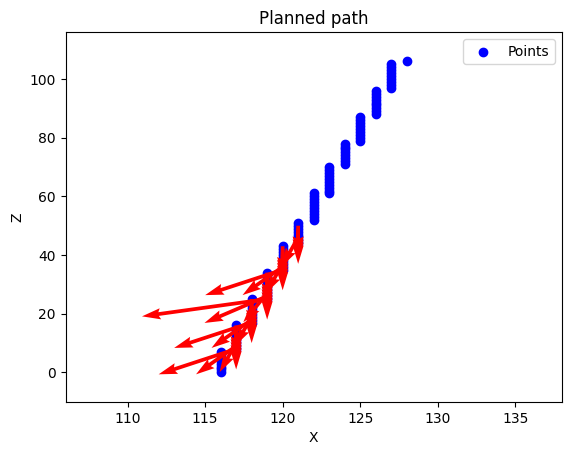

In [21]:
path = convert(path)
res = frame.compute_feasible_path(path, save_heading=True)
first_non_feasible = plot_points(path, -1, show_heading_to_non_fesibles=res)


In [22]:
print(res)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


heading = 0.0


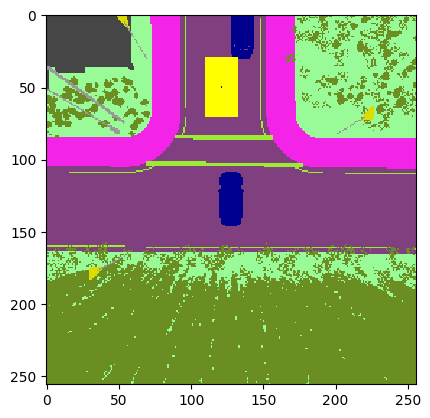

In [23]:

f = frame.get_color_frame()
print (f"heading = {math.degrees(first_non_feasible.heading)}")
draw_safe_square(f, (first_non_feasible.x, first_non_feasible.z), math.degrees(first_non_feasible.heading))
plt.imshow(f, interpolation='nearest')

heading = 0.0


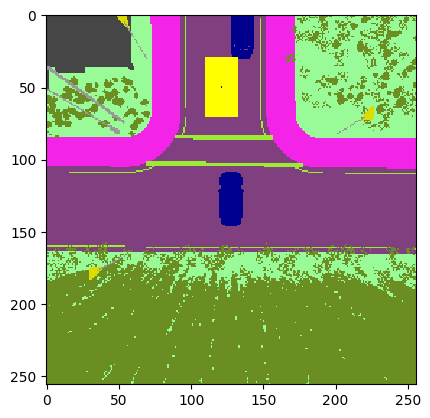

In [24]:
f = frame.get_color_frame()
print (f"heading = {math.degrees(first_non_feasible.heading)}")
draw_safe_square(f, (first_non_feasible.x, first_non_feasible.z), -0)
plt.imshow(f, interpolation='nearest')

In [25]:
frame.get_frame()[first_non_feasible.z, first_non_feasible.x, 0]

#cv2.imwrite("/home/cristiano/Documents/outp.png", f)


1.0